# Ground Motion Displacement RMS vs Time

*an example simple tutorial for getting seismic data, computing the power spectral densities, extracting the RMS and plotting*

Required:

- python
- obspy (and its dependencies)
- pandas
- jupyter
- notebook

this should be easy to set up in a conda env: ``conda create -n covid python=3.7 obspy pandas jupyter notebook``

Author: Thomas Lecocq @seismotom, Fred Massin @fmassin

## Step 1: imports

In [7]:
import datetime
import os
import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.signal import PPSD


## Step 2: Define Start/End dates and Seismic Channel

You'll have to make sure the seed_id you request is indeed available from the ``data_provider``

In [11]:
start = UTCDateTime("2020-03-13")
end = UTCDateTime() # means "now"

network = "BE"
station = "UCC"
location = ""
channel = "HHZ"
dataset = "example"

data_provider = "ODC"
logo = None #plt.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Logo_SED_2014.png/220px-Logo_SED_2014.png')
bans = {"2020-03-10":'Groups >1000 banned', 
        "2020-03-17":'All gathering banned'}


## Step 3: Download the seismic waveform data

This step is coded so that only the last day is redownloaded iif the daily files are present on the disk.

The request gets the target day +- 30 minutes to avoid having gaps at the end of each day (need 1 window covering midnight).

In [4]:
datelist = pd.date_range(start.datetime, end.datetime, freq="D")
c = Client(data_provider)

for day in datelist:
    fn = day.strftime(dataset+"%Y-%m-%d.mseed")
    print(fn)
    if day != datelist[-1] and os.path.isfile(fn):
        continue
    else:
        st = c.get_waveforms(network, station, location, channel,
                             UTCDateTime(day)-1801, UTCDateTime(day)+86400+1801, attach_response=True)
        print(st)
        st.write(fn)
resp = c.get_stations(UTCDateTime(day), network=network, station=station, location=location,
                      channel=channel, level="response")
print(resp)


2020-03-13.mseed
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-12T23:29:55.590000Z - 2020-03-14T00:30:04.900000Z | 100.0 Hz, 9000932 samples
2020-03-14.mseed
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-13T23:29:55.830000Z - 2020-03-15T00:30:02.060000Z | 100.0 Hz, 9000624 samples
2020-03-15.mseed
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-14T23:29:57.670000Z - 2020-03-16T00:30:01.760000Z | 100.0 Hz, 9000410 samples
2020-03-16.mseed
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-15T23:29:56.830000Z - 2020-03-17T00:30:02.680000Z | 100.0 Hz, 9000586 samples
2020-03-17.mseed
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-16T23:29:57.730000Z - 2020-03-18T00:30:03.100000Z | 100.0 Hz, 9000538 samples
2020-03-18.mseed
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-17T23:29:58.250000Z - 2020-03-19T00:30:02.820000Z | 100.0 Hz, 9000458 samples
2020-03-19.mseed
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-18T23:29:57.950000Z - 2020-03-20T00:30:03.140000Z | 100.0 Hz, 9000520 samples
2020-03-20.mseed
1 Trace(s)

## Step 4: Compute PPSDs using custom paramters

These parameters are set to allow the PSDs to be "nervous", not as smooth as the default PQLX ones.

In [13]:
for day in datelist:
    fn_in = day.strftime(dataset+"%Y-%m-%d.mseed")
    if day == datelist[-1] :
        continue
    stall = read(fn_in)
    for mseedid in list(set([tr.id for tr in stall])):
        fn_out = day.strftime(dataset+"%Y-%m-%d-"+mseedid+".npz")
        if os.path.isfile(fn_out):
            print("%s done already."%fn_out)
            continue
        st = stall.select(id=mseedid)
        st.attach_response(resp)
        ppsd = PPSD(st[0].stats, metadata=resp,
                    ppsd_length=1800, overlap=0.5,
                    period_smoothing_width_octaves=0.025,
                    period_step_octaves=0.0125,
                    period_limits=(0.008, 50),
                    db_bins=(-200, 20, 0.25))
        ppsd.add(st)
        ppsd.save_npz(fn_out[:-4])
        print(st)
        del st, ppsd
    del stall


1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-12T23:29:55.590000Z - 2020-03-14T00:30:04.900000Z | 100.0 Hz, 9000932 samples
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-13T23:29:55.830000Z - 2020-03-15T00:30:02.060000Z | 100.0 Hz, 9000624 samples
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-14T23:29:57.670000Z - 2020-03-16T00:30:01.760000Z | 100.0 Hz, 9000410 samples
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-15T23:29:56.830000Z - 2020-03-17T00:30:02.680000Z | 100.0 Hz, 9000586 samples
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-16T23:29:57.730000Z - 2020-03-18T00:30:03.100000Z | 100.0 Hz, 9000538 samples
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-17T23:29:58.250000Z - 2020-03-19T00:30:02.820000Z | 100.0 Hz, 9000458 samples
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-18T23:29:57.950000Z - 2020-03-20T00:30:03.140000Z | 100.0 Hz, 9000520 samples
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-19T23:29:58.210000Z - 2020-03-21T00:30:01.520000Z | 100.0 Hz, 9000332 samples
1 Trace(s) in Stream:
BE

## Step 5: Reload daily PSDs from the disk and create a single PPSD object:

In [14]:
ppsds={}
for day in datelist:
    for fn in glob.glob(day.strftime(dataset+"%Y-%m-%d-*.npz")):
        mseedid = fn.split("-")[3][:-4]
        if mseedid not in ppsds:
            ppsds[mseedid] = PPSD.load_npz(fn,True)
        else:
            ppsds[mseedid].add_npz(fn)

/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file 'example2020-03-14-BE.UCC..HHZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file 'example2020-03-15-BE.UCC..HHZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file 'example2020-03-16-BE.UCC..HHZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file 'example2020-03-17-BE.UCC..HHZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: U

## Step 6: Standard plots:

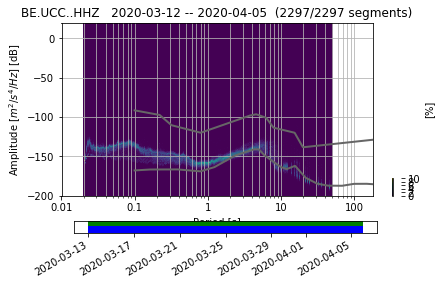

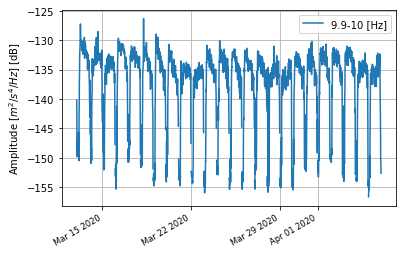

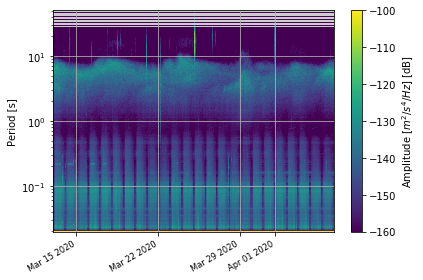

[None]

In [15]:
[ppsd.plot(max_percentage=10) for mseedid, ppsd in ppsds.items()]
[ppsd.plot_temporal(0.10) for mseedid, ppsd in ppsds.items()]
[ppsd.plot_spectrogram(clim=(-160,-100)) for mseedid, ppsd in ppsds.items()]

## Step 7: Process PSDs to extract the RMS(displacement)

This can be done for multiple filters at once (``freqs`` below):

In [17]:
# Define frequency bands of interest:
freqs = [(0.1,1.0),(1.0,20.0),(4.0,14.0),(4.0,20.0)]


def rms(s, f):
    # Parseval: the RMS in time domain is the sqrt of the integral of the power spectrum
    return np.sqrt(np.trapz(s, f))

displacement_RMS = {}
for mseedid, ppsd in ppsds.items():
    per = ppsd.period_bin_centers
    displacement_RMS[mseedid] = []
    for psd in ppsd.psd_values:
        RMS = {}
        for fmin, fmax in freqs:
            ix = np.where((per>=1.0/fmax) & (per<=1.0/fmin))

            # acceleration power spectrum in Hz
            spec = psd.copy()[ix][::-1]
            f = 1.0/per.copy()[ix][::-1]

            # remove NaNs from the list
            valid = np.where(np.isfinite(spec))[0]
            spec = spec[valid]
            f = f[valid]

            w2f = (2.0 * np.pi * f)

            # The acceleration amplitude spectrum (dB to Power! = divide by 10 and not 20!)
            amp = 10.0**(spec/10.) 

            # velocity spectrum (divide by omega**2)
            vamp = amp / w2f**2

            # displacement spectrum (divide by omega**2)
            damp =  vamp / w2f**2

            RMS["%.1f-%.1f"%(fmin, fmax)] = rms(damp, f)

        displacement_RMS[mseedid].append(RMS)
        index = pd.DatetimeIndex([d.datetime for d in ppsd.times_processed])
    displacement_RMS[mseedid] = pd.DataFrame(displacement_RMS[mseedid], index=index)
    print(mseedid," rms done.")

BE.UCC..HHZ  rms done.


## Step 8: Custom plot for a single frequency band:

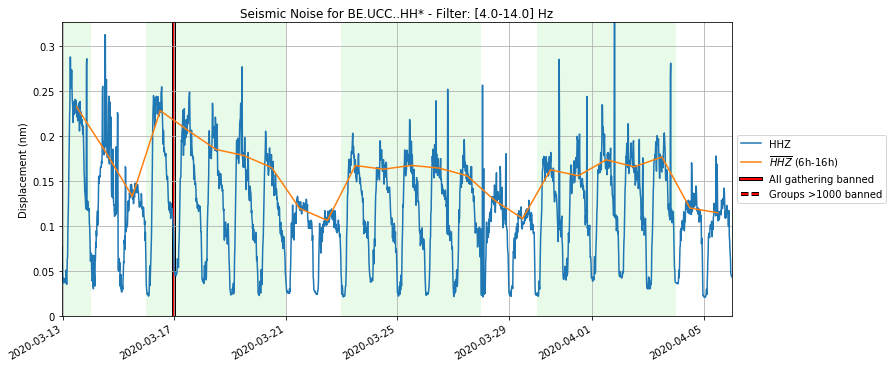

In [27]:
band = "4.0-14.0"

for channelcode in list(set([k[:-1] for k in displacement_RMS])):
    fig = plt.figure(figsize=(12,6))
    if logo is not None:
        fig.figimage(logo, 40, 40, alpha=.4, zorder=1)
    
    data={}
    for o in 'ZEN':
        if channelcode+o not in displacement_RMS :
            continue
        data[channelcode[-2:]+o] = displacement_RMS[channelcode+o][band]
        main=channelcode[-2:]+o
        
    if len(data.keys())>1:
        main=channelcode[-2:]+'*'
        data[channelcode[-2:]+'*'] = data[main].copy() # for the sum
        for i,t in enumerate(data['S'].index):        
            d[i] = 0
            for o in data:
                if o == 'S':
                    continue
                if len(data[o].index)-1<i:
                    break
                if abs(data[o].index[i].timestamp()-data['S'].index[i].timestamp())<60:
                    d[i] += data[o][i]**2
            d[i] = d[i]**.5
    
    plt.plot(data[main].index, data[main], label = main)
    
    for o in data:
        rs = data[o].copy().between_time("6:00", "16:00")
        rs = rs.resample("1D" ).median().tshift(12, "H")
        plt.plot(rs.index, rs, 
                 label="$\overline{%s}$ (6h-16h)"%o)#, c='purple')

    

    # Get normal business days and set their background color to green
    db = pd.bdate_range(start.datetime, end.datetime)
    for dbi in db:
        plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                    facecolor='lightgreen', edgecolor="none",
                    alpha=0.2, zorder=-10)

    scale = 1e9
    plt.ylim(0,np.percentile(data[main],95)*1.5)
    ticks = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x*scale))
    plt.gca().yaxis.set_major_formatter(ticks)
    plt.ylabel("Displacement (nm)")

    plt.title('Seismic Noise for %s - Filter: [%s] Hz' % (channelcode+'*',
                                                          band))
    plt.xlim(data[main].index.min(), data[main].index.max())
    fig.autofmt_xdate()
    plt.grid(True, zorder=-1)
    plt.gca().set_axisbelow(True)    
    for iban,ban in enumerate(bans.keys()):
        plt.axvline(UTCDateTime(ban).datetime,
                    color='r', 
                    linewidth=2,
                    linestyle=['-', '--', '-.', ':'][iban],
                    path_effects=[pe.withStroke(linewidth=4, foreground="k")],
                    zorder=-9,
                    label=bans[ban])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    fig.savefig(channelcode+".pdf",bbox_inches='tight')
    fig.savefig(channelcode+".png",bbox_inches='tight')